In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from config import DATA_DIR

In [2]:
IMAGE_NAME = "317947"
IMAGE_PATH = DATA_DIR.joinpath(f"{IMAGE_NAME}.jpg")

In [3]:
image = cv2.imread(filename=str(IMAGE_PATH))
image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
print(f"Loaded image {IMAGE_PATH} with shape: {image.shape}")

Loaded image C:\Users\punit\projects\research\clotscape\data\317947.jpg with shape: (742, 932, 3)


In [4]:
def save_image(image, filename):
    if len(image.shape) == 2:  # Grayscale image
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, facecolor='white', dpi=300)
        plt.close()
    elif image.shape[2] == 3:  # RGB image
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, facecolor='white', dpi=300)
        plt.close()
    else:  # BGR image (assuming OpenCV format)
        image = image.astype(np.float32)
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, facecolor='white', dpi=300)
        plt.close()

## Denoising

In [5]:
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet


def gaussian_filtering(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def median_filtering(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def non_local_means_denoising(image, h=10, search_window=21, block_size=7):
    return cv2.fastNlMeansDenoisingColored(image, None, h, h, search_window, block_size)

def tv_denoising(image, weight=0.1):
    denoised = denoise_tv_chambolle(image, weight=weight)
    return denoised

def bilateral_denoising(image, win_size=5, sigma_color=0.1, sigma_spatial=15):
    denoised = denoise_bilateral(image, win_size=win_size, sigma_color=sigma_color, sigma_spatial=sigma_spatial, channel_axis=2)
    return denoised

def wavelet_denoising(image, method='BayesShrink', mode='soft', wavelet='db1', rescale_sigma=True):
    denoised = denoise_wavelet(image, method=method, mode=mode, wavelet=wavelet, rescale_sigma=rescale_sigma)
    return denoised

In [6]:
# Apply denoising methods
gaussian_denoised = gaussian_filtering(image, kernel_size=(5, 5), sigma=1.5)
median_denoised = median_filtering(image, kernel_size=5)
nlm_denoised = non_local_means_denoising(image, h=10, search_window=21, block_size=7)
tv_denoised = tv_denoising(image, weight=0.1)
bilateral_denoised = bilateral_denoising(image, win_size=5, sigma_color=0.1, sigma_spatial=15)
wavelet_denoised = wavelet_denoising(image, method='BayesShrink', mode='soft', wavelet='db1', rescale_sigma=True)

In [7]:
DENOISE_DIR = DATA_DIR.joinpath(f"denoise")
DENOISE_DIR.mkdir(exist_ok=True)

save_image(gaussian_denoised, str(DENOISE_DIR / f"{IMAGE_NAME}_gaussian_denoised.jpg"))
save_image(median_denoised, str(DENOISE_DIR / f"{IMAGE_NAME}_median_denoised.jpg"))
save_image(nlm_denoised, str(DENOISE_DIR / f"{IMAGE_NAME}_nlm_denoised.jpg"))
save_image(tv_denoised, str(DENOISE_DIR / f"{IMAGE_NAME}_tv_denoised.jpg"))
save_image(bilateral_denoised, str(DENOISE_DIR / f"{IMAGE_NAME}_bilateral_denoised.jpg"))
save_image(wavelet_denoised, str(DENOISE_DIR / f"{IMAGE_NAME}_wavelet_denoised.jpg"))
print(f"Denoised images saved in {DENOISE_DIR}")

Denoised images saved in C:\Users\punit\projects\research\clotscape\data\denoise


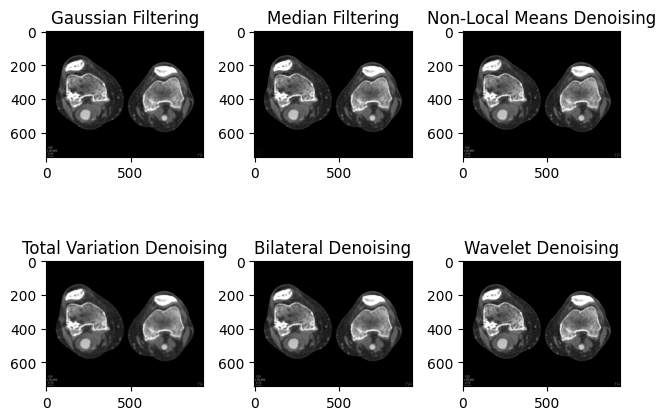

In [8]:
# Display the results
plt.figure()
plt.subplot(2, 3, 1), plt.imshow(gaussian_denoised), plt.title("Gaussian Filtering")
plt.subplot(2, 3, 2), plt.imshow(median_denoised), plt.title("Median Filtering")
plt.subplot(2, 3, 3), plt.imshow(nlm_denoised), plt.title("Non-Local Means Denoising")
plt.subplot(2, 3, 4), plt.imshow(tv_denoised), plt.title("Total Variation Denoising")
plt.subplot(2, 3, 5), plt.imshow(bilateral_denoised), plt.title("Bilateral Denoising")
plt.subplot(2, 3, 6), plt.imshow(wavelet_denoised), plt.title("Wavelet Denoising")

plt.tight_layout()
plt.show()

# Normalization

In [9]:
from skimage.exposure import equalize_adapthist

def intensity_windowing(image, window_level, window_width):
    window_min = window_level - (window_width // 2)
    window_max = window_level + (window_width // 2)
    image_windowed = np.clip(image, window_min, window_max)
    image_windowed = (image_windowed - window_min) / (window_max - window_min) * 255
    return image_windowed.astype(np.uint8)

def z_score_normalization(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized = (image - mean) / std
    return normalized

def percentile_normalization(image, lower_percentile=5, upper_percentile=95):
    lower_value = np.percentile(image, lower_percentile)
    upper_value = np.percentile(image, upper_percentile)
    normalized = (image - lower_value) / (upper_value - lower_value)
    normalized = np.clip(normalized, 0, 1)
    return normalized

def clahe_normalization(image, kernel_size=None, clip_limit=0.01, nbins=256):
    normalized = equalize_adapthist(image, kernel_size=kernel_size, clip_limit=clip_limit, nbins=nbins)
    return normalized

In [10]:
windowed_image = intensity_windowing(image, window_level=40, window_width=80)
z_score_normalized_image = z_score_normalization(image)
percentile_normalized_image = percentile_normalization(image, lower_percentile=5, upper_percentile=95)
clahe_normalized_image = clahe_normalization(image, kernel_size=(8, 8), clip_limit=0.01, nbins=256)

In [11]:
# Save normalized images
NORMALIZE_DIR = DATA_DIR.joinpath(f"normalize")
NORMALIZE_DIR.mkdir(exist_ok=True)
save_image(windowed_image, str(NORMALIZE_DIR / f"{IMAGE_NAME}_windowed.jpg"))
save_image(z_score_normalized_image, str(NORMALIZE_DIR / f"{IMAGE_NAME}_z_score_normalized.jpg"))
save_image(percentile_normalized_image, str(NORMALIZE_DIR / f"{IMAGE_NAME}_percentile_normalized.jpg"))
save_image(clahe_normalized_image, str(NORMALIZE_DIR / f"{IMAGE_NAME}_clahe_normalized.jpg"))
print(f"Normalized images saved in {NORMALIZE_DIR}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Normalized images saved in C:\Users\punit\projects\research\clotscape\data\normalize


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Axes: title={'center': 'CLAHE Normalization'}>,
 Text(0.5, 1.0, 'CLAHE Normalization'))

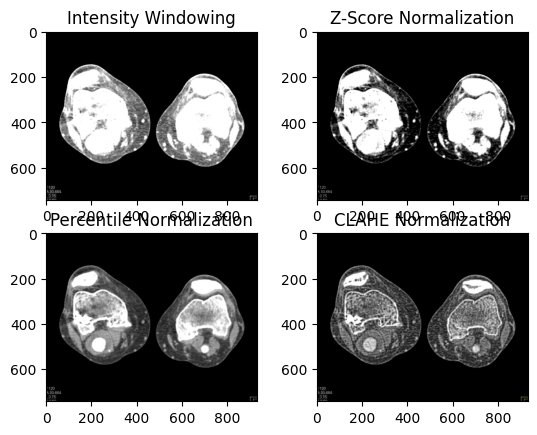

In [12]:
# Display the results
plt.figure()
plt.subplot(2, 2, 1), plt.imshow(windowed_image, cmap='gray'), plt.title("Intensity Windowing")
plt.subplot(2, 2, 2), plt.imshow(z_score_normalized_image, cmap='gray'), plt.title("Z-Score Normalization")
plt.subplot(2, 2, 3), plt.imshow(percentile_normalized_image, cmap='gray'), plt.title("Percentile Normalization")
plt.subplot(2, 2, 4), plt.imshow(clahe_normalized_image, cmap='gray'), plt.title("CLAHE Normalization")

# Edge and Contour Detection

In [13]:
from skimage import filters


def canny_edge_detection(image, sigma=0.33):
    # Compute median of the image for more dynamic thresholding
    v = np.median(image)

    # Apply automatic Canny edge detection using computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged

def sobel_edge_detection(image):
    # Convert image to float32 to prevent overflow/underflow issues
    image = image.astype(np.float32)
    
    # Compute gradients along the x and y axes
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate the gradient magnitude and normalize the result
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX)
    return sobel.astype(np.uint8)

def log_edge_detection(image, sigma=2):
    log_edges = filters.laplace(filters.gaussian(image, sigma=sigma))
    log_edges = (log_edges - log_edges.min()) / (log_edges.max() - log_edges.min()) * 255
    return log_edges.astype(np.uint8)


def scharr_edge_detection(image):
    # Convert image to float32 to prevent overflow/underflow issues
    image = image.astype(np.float32)

    # Compute gradients along the x and y axes
    scharrx = cv2.Scharr(image, cv2.CV_32F, 1, 0)
    scharry = cv2.Scharr(image, cv2.CV_32F, 0, 1)

    # Calculate the gradient magnitude and normalize the result
    scharr = np.sqrt(scharrx**2 + scharry**2)
    scharr = cv2.normalize(scharr, None, 0, 255, cv2.NORM_MINMAX)
    return scharr.astype(np.uint8)

In [14]:
# Apply edge and contour detection methods
canny_edges = canny_edge_detection(image, sigma=0.33)
sobel_edges = sobel_edge_detection(image)
log_edges = log_edge_detection(image, sigma=1)
scharr_edges = scharr_edge_detection(image)

In [15]:
# Save edge detection results
EDGE_DETECTION_DIR = DATA_DIR.joinpath("edge_detection")
EDGE_DETECTION_DIR.mkdir(exist_ok=True)

save_image(canny_edges, str(EDGE_DETECTION_DIR / f"{IMAGE_NAME}_canny_edges.jpg"))
save_image(sobel_edges, str(EDGE_DETECTION_DIR / f"{IMAGE_NAME}_sobel_edges.jpg"))
save_image(log_edges, str(EDGE_DETECTION_DIR / f"{IMAGE_NAME}_log_edges.jpg"))
save_image(scharr_edges, str(EDGE_DETECTION_DIR / f"{IMAGE_NAME}_scharr_edges.jpg"))

print(f"Edge and contour detection results saved in {EDGE_DETECTION_DIR}")

Edge and contour detection results saved in C:\Users\punit\projects\research\clotscape\data\edge_detection


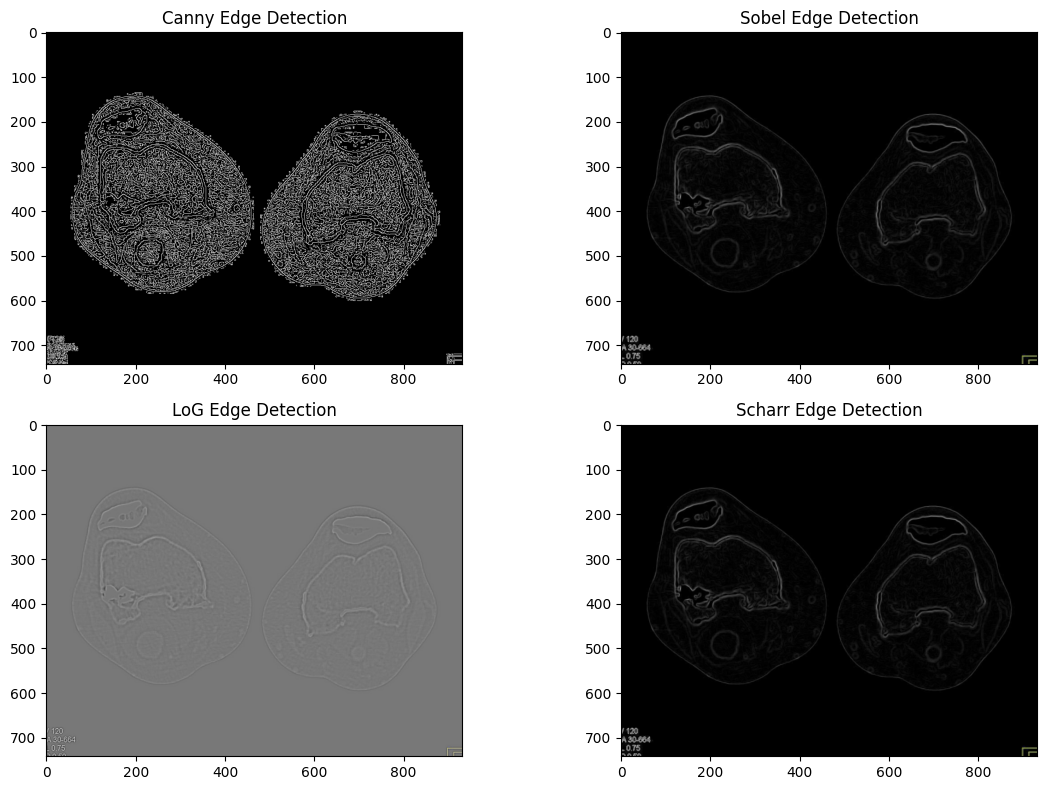

In [16]:
# Display the results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(canny_edges, cmap='gray'), plt.title("Canny Edge Detection")
plt.subplot(2, 2, 2), plt.imshow(sobel_edges, cmap='gray'), plt.title("Sobel Edge Detection")
plt.subplot(2, 2, 3), plt.imshow(log_edges, cmap='gray'), plt.title("LoG Edge Detection")
plt.subplot(2, 2, 4), plt.imshow(scharr_edges, cmap='gray'), plt.title("Scharr Edge Detection")
plt.tight_layout()
plt.show()